In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

#from torch.utils.tensorboard import SummaryWriter

import sklearn
import functools
import operator

import sys

sys.path.insert(1,"/home/sbulusu/qcd_ml/neural_networks/libs/")

import dataset_class_gsimage
import aenc_torch_net_class
#import aenc_utils
import utils

from tqdm.notebook import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Utilizing CUDA")
else:
    device = torch.device("cpu")
    print("Utilizing CPU")
    
cpu_device = torch.device("cpu")

Utilizing CUDA


In [3]:
"""Download dataset provided by pytorch"""
"""
from torchvision import datasets, transforms
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
"""

"\nfrom torchvision import datasets, transforms\n# MNIST Dataset\ntransform = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Normalize(mean=[0.5], std=[0.5])])\n\ntrain_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)\ntest_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)\n\n# Data Loader (Input Pipeline)\ntrain_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)\ntest_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)\n"

NameError: name 'train_dataset' is not defined

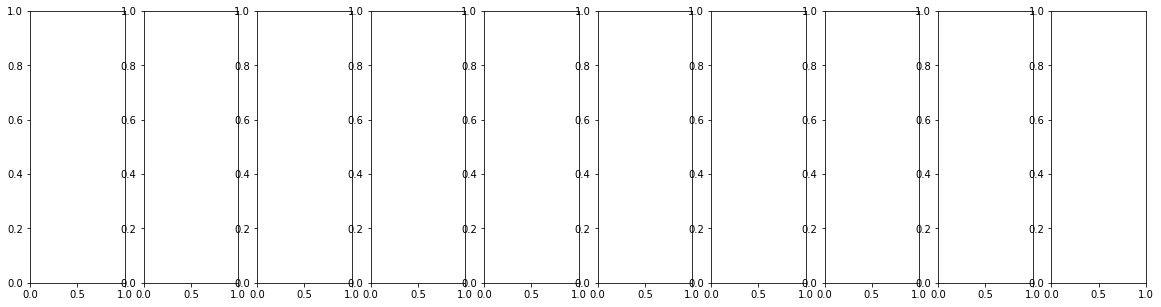

In [4]:
plt.rcParams['figure.figsize'] = [20, 5]
n_load = 10
i = 0

fig, ax = plt.subplots(1,n_load)
for i in range(n_load):
    ax[i].imshow(train_dataset[i][0].detach().cpu().numpy().reshape([28,28]))
#plt.show()
#print(dataset.get_image(i)[1])

In [ ]:
"""...But we will be using our custom dataset and functions!"""

#mnist_image_folder = "../data/mnist/"
#folder of the dataset
mnist_image_folder = "/media/data/sbulusu/datasets/mnist/mnist_images/"
mnist_image_names = os.listdir(mnist_image_folder)
#relative paths of all images to mnist_image_folder
mnist_image_paths = glob.glob("mnist/*")
image_size = [1,28,28]
#label_path_csv = "../data/mnist_labels.csv"
label_path_csv = "/media/data/sbulusu/datasets/mnist/mnist_labels.csv"
dataset = dataset_class_gsimage.image_dataset(mnist_image_folder, mnist_image_paths, image_size, label_path_csv, transform="default", device=device)
#dataset = dataset_class_gsimage.image_dataset(mnist_image_folder, mnist_image_paths, image_size, label_path_csv, transform=None, device=device)
#name of the attribute in the csv file
target_attributes = ["number"]
dataset.set_label_names(target_attributes)

In [ ]:
dataset.transform = torchvision.transforms.Compose([
                dataset_class_gsimage.send_to_device(target_device=cpu_device),
                #dataset_class_gsimage.numpy(typ=np.uint8),
                dataset_class_gsimage.torch_tensor(typ=torch.uint8),
                #dataset_class_gsimage.roll_channel_axis(old_pos=0, new_pos=-1, device=torch.device("cpu")),
                torchvision.transforms.ToPILImage(mode=None),
                torchvision.transforms.RandomResizedCrop(size=(28,28),scale=(0.8, 1.0), ratio=(0.75, 1.33333), interpolation=2),
                torchvision.transforms.RandomRotation((-30,+30), resample=False, expand=False, center=None),
                torchvision.transforms.ToTensor(),
                dataset_class_gsimage.send_to_device(target_device=device),
                dataset_class_gsimage.min_max_scaler(device=device),
                torchvision.transforms.Normalize(mean=[0.5], std=[0.5]),
                torchvision.transforms.RandomApply([dataset_class_gsimage.add_normal_noise(0.,0.1,device=device)], p=0.5),
                torchvision.transforms.RandomErasing(p=0.5, scale=(0.01, 0.05), ratio=(0.3, 3.3), value=0, inplace=False)
            ])

In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]
n_load = 10
i = 0

fig, ax = plt.subplots(1,n_load)
for i in range(n_load):
    ax[i].imshow(dataset.get_image(i)[0].detach().cpu().numpy().reshape([28,28]))
#plt.show()
#print(dataset.get_image(i)[1])

In [ ]:
dataset.transform = torchvision.transforms.Compose([
                dataset_class_gsimage.min_max_scaler(device=device),
                torchvision.transforms.Normalize(mean=[0.0], std=[1.0]),
                #torchvision.transforms.RandomApply([dataset_class_gsimage.add_normal_noise(0.,0.1,device=device)], p=0.5),
                #torchvision.transforms.RandomErasing(p=0.5, scale=(0.01, 0.05), ratio=(0.3, 3.3), value=0, inplace=False)
            ])

In [ ]:

"""Manually set network structure"""
"""
    This list can be loaded into the constructor of the Net neural network class, to automatically generate the network structure
    type = pointer to the layer function'
    layer_pars = parameters which must be given to the layer function in order to initialize it
    act_func = activation function to be applied directly after feeding to the corresponding layer
    dropout = certain neurons cna be dropped out if specified
"""

input_size = dataset.get_input_size()
output_size = input_size

latent_size = 10

fc_input_size = np.product(input_size)
print(fc_input_size)

In [ ]:
act_func = torch.relu
#act_func = F.leaky_relu
#act_func = torch.sigmoid

encoder_struct = []
encoder_struct.append( {"type": nn.Flatten, "layer_pars": {"start_dim": 1}} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size, "out_features": fc_input_size//4}, "bias": True, "act_func": act_func} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//4, "out_features": fc_input_size//8}, "bias": True, "act_func": act_func} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//8, "out_features": fc_input_size//16}, "bias": True, "act_func": act_func} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//16, "out_features": latent_size}, "bias": True, "act_func": act_func} )

encoder_sizes = utils.calc_layer_sizes(input_size, encoder_struct)
print(encoder_sizes)

latent_size = encoder_sizes[-1]
input_size = encoder_sizes[0]

In [ ]:
act_func = torch.relu
#act_func = F.leaky_relu
#act_func = torch.sigmoid

decoder_struct = []

decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": latent_size, "out_features": fc_input_size//16}, "bias": True, "act_func": act_func} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//16, "out_features": fc_input_size//8}, "bias": True, "act_func": act_func} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//8, "out_features": fc_input_size//4}, "bias": True, "act_func": act_func} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//4, "out_features": fc_input_size}, "bias": True, "act_func": torch.sigmoid} )
decoder_struct.append( {"type": utils.Reshape, "layer_pars": {"new_shape": input_size}} )
#fixed_net_struct.append( {"type": nn.Softmax, "layer_pars": {"dim": 1}} )
#dim 0 or 1???
#fixed_net_struct.append( {"type": nn.ConvTranspose2d, "layer_pars": {"in_channels": 1, "out_channels": 1, "kernel_size": [1,1], "stride": 1, "padding": 1, "bias": True}, "act_func": act_func} )

decoder_sizes = utils.calc_layer_sizes(latent_size, decoder_struct)

print(decoder_sizes)

In [ ]:
"""
HYPERPARAMETERS
"""

random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

#val_epochs = [10,20,30,40,50,60,70]
#val_epochs = [1,2]
#val_epochs = [1,2,3,4,5,6,7,8,9,10]
val_epochs = list(range(0,100))

#save states of the network for particular epochs, sate can be reloaded afterwards!
save_state_epochs = [10000]


"""create list of parameters manually"""

hyper_parameters = {}

loss_func_kwargs = {"reduction": "sum"}
#hyper_parameters["loss_func"] = nn.CrossEntropyLoss
#hyper_parameters["loss_func"] = nn.BCELoss
hyper_parameters["loss_func"] = nn.MSELoss
hyper_parameters["optimizer"] = optim.Adam
hyper_parameters["batch_size"] = 20 
hyper_parameters["lr"] = 0.00001

hyper_parameters["val_method"] = "holdout"
hyper_parameters["val_method_pars"] = {"train" : 0.9, "val" : 0.1, "test" : 0.}
#hyper_parameters["val_method"] = "k_fold"
#hyper_parameters["val_method_pars"] = 5

In [ ]:
epochs = max(val_epochs)+1

lr=hyper_parameters["lr"]
batch_size = hyper_parameters["batch_size"]
loss_func = hyper_parameters["loss_func"](**loss_func_kwargs)
#loss_func = hyper_parameters["loss_func"]()
val_method = hyper_parameters["val_method"]
val_method_pars = hyper_parameters["val_method_pars"]
optimizer_type = hyper_parameters["optimizer"]

val_pred_paths = []
val_label_paths = []

train_loss = np.zeros(epochs)
val_loss = np.zeros(len(val_epochs))

net_state_paths = []

#create training log
log_file_name = "log.txt"
log_file = open(log_file_name, "w")

In [ ]:
"""Generate network class instance"""
net = aenc_torch_net_class.AutoEncoder(encoder_struct=encoder_struct, decoder_struct=decoder_struct, input_size=input_size, latent_size=latent_size, device=device)
net.set_batch_size(batch_size)
net.to(device)
net_parameters = net.parameters()

optimizer = optimizer_type(net_parameters, lr=lr)

In [ ]:
"""Load and split data"""
split_indices = utils.load_split_indices(dataset=dataset, batch_size=batch_size, method=val_method, method_pars=val_method_pars, shuffle=True, random_seed=random_seed, log_file=log_file)

train_indices = split_indices[0][0]
val_indices = split_indices[0][1]
test_indices = split_indices[0][2]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

In [ ]:
"""Load data provided by pytorch"""
"""
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader))
print(len(val_loader))
"""

In [ ]:
val_dir = "val/"
try:
    os.makedirs(val_dir)
except FileExistsError:
    pass
train_state_dir = "net_states/"
try:
    os.makedirs(train_state_dir)
except FileExistsError:
    pass

epoch = 0
val_i = 0
train_start_time = time.time()
for epoch in tqdm(range(epochs)):
    
    batch_nr = 0
    epoch_loss = np.zeros(len(train_loader))
    
    """Actual training step"""
    for train_mini_batch in tqdm(train_loader):
        
        batch_loss, train_output = utils.step(net, train_mini_batch[0], train_mini_batch[0], loss_func, optimizer, device, mode="train", log_file=log_file)
        epoch_loss[batch_nr] = batch_loss.item()
        batch_nr += 1
    
    mean_epoch_loss = epoch_loss.mean()
    train_loss[epoch] = mean_epoch_loss
    print(f"mean epoch {epoch} train loss: {mean_epoch_loss}\n")
    
    
    """save the neural networks state"""
    if epoch in save_state_epochs:
        train_state_epoch_file_path = train_state_dir + f"state_epoch_{epoch}"
        #train_state = {"epoch" : epoch, "state_dict": net.state_dict(), "optimizer": optimizer.state_dict()}
        #torch.save(train_state, train_state_epoch_file_path)
        torch.save(net.state_dict(), train_state_epoch_file_path)
        net_state_paths.append(train_state_epoch_file_path)
        print(f"saved model from epoch {epoch}")
        
    """
    Validation
    """
    #val_epochs = [100000]
    if epoch in val_epochs:
        val_label = []
        val_pred = []
        
        val_batch_nr = 0
        val_epoch_loss = np.zeros(len(val_loader))
        
        for val_mini_batch in val_loader:
            label_batch = val_mini_batch[1]
            val_label.append(label_batch.detach().cpu().numpy())
            val_batch_loss, val_output = utils.step(net, val_mini_batch[0], val_mini_batch[0], loss_func, optimizer, device, mode="val", log_file=log_file)
            val_epoch_loss[val_batch_nr] = val_batch_loss.item()
            val_pred.append(val_output.detach().cpu().numpy())
            
            if val_batch_nr == 0:
                num_images = 10
                fig, ax = plt.subplots(1,num_images)
                for i in range(num_images):
                    ax[i].imshow(val_pred[-1].reshape((batch_size,1,28,28))[i,0])
                plt.show()
                #ax[1].imshow(val_label[0].reshape((batch_size,1,28,28))[0,0])
            
            val_batch_nr += 1
            
        mean_val_epoch_loss = val_epoch_loss.mean()
        val_loss[val_i] = mean_val_epoch_loss
        print(f"mean epoch {epoch} val loss: {mean_val_epoch_loss}\n")
        
        val_i += 1
        
        print(f"Saving validation results for epoch {epoch}")
        
        val_pred_path = val_dir + "/" + f"val_epoch_{epoch}_pred"
        val_label_path = val_dir + "/" + f"val_epoch_{epoch}_labels"
        #print(np.array(functools.reduce(operator.iconcat, val_pred, [])))
        np.array(functools.reduce(operator.iconcat, val_pred, [])).tofile(val_pred_path, sep=" ")
        np.array(functools.reduce(operator.iconcat, val_label, [])).tofile(val_label_path, sep=" ")
        #np.array(val_pred).tofile(val_pred_path)
        #np.array(val_label).tofile(val_pred_label)
        
        val_pred_paths.append(val_pred_path)
        val_label_paths.append(val_label_path)
        print(f"validation prediction: {val_pred_path}")
        print(f"validation label: {val_label_path}")
        
log_file.close()
train_end_time = time.time()

In [ ]:
print(f"training time: {train_end_time-train_start_time}s")

In [ ]:
"""Plot training loss curve and save as image"""
plt.rcParams['figure.figsize'] = [10, 10]
loss_img_file_name = "train_loss.png"
x_epochs = range(epochs)
fig, ax = plt.subplots()
ax.plot(x_epochs, train_loss, label="train loss")
ax.plot(val_epochs, val_loss, label="val loss")
leg = ax.legend()
#plt.title()
plt.xlabel("epoch")
#plt.ylabel("loss")
plt.savefig(loss_img_file_name)
plt.show()
plt.close()
train_loss_txt_file_name = "train_loss.txt"
np.savetxt(train_loss_txt_file_name, train_loss)
val_loss_txt_file_name = "val_loss.txt"
np.savetxt(val_loss_txt_file_name, val_loss)

In [ ]:
train_state_file_path = train_state_dir + f"state_epoch_{epoch}"
#train_state = {"epoch" : epoch, "state_dict": net.state_dict(), "optimizer": optimizer.state_dict()}
torch.save(net.state_dict(), train_state_file_path)
net_state_paths.append(train_state_file_path)
print(f"saved model from epoch {epoch}")

In [ ]:
load_epoch = epoch
print(f"loading model from epoch {load_epoch}")
net_state_path = f"net_states/state_epoch_{load_epoch}"
net.load_state_dict(torch.load(net_state_path))
net.eval()

In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]
test_image, test_label = dataset[0]
indices = np.arange(0,10)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=test_sampler)
test_images = []
outputs = []
for test_batch in train_loader:
    test_image = test_batch[0].to(device)
    test_images.append(test_image)
    #plt.imshow(test_image.cpu()[0,0])
    net.eval()
    output = net.forward(test_image.float())
    outputs.append(output)

num_images = len(outputs)
fig, ax = plt.subplots(2,num_images)
for image_i in range(num_images):
    ax[0, image_i].imshow(test_images[image_i].cpu()[0,0])
    ax[1, image_i].imshow(outputs[image_i].detach().cpu()[0,0])

In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]
num_samples = 10
#latent_samples = torch.randint(low=1, high=1000, size=(num_samples, latent_size) )
latent_samples = torch.randn(size=(num_samples, latent_size) )

output = net.decoder(latent_samples.to(device).float())
print(output.size())
print(len(output))
fig, ax = plt.subplots(1,num_samples)
for i in range(num_samples):
    ax[i].imshow(output.detach().cpu()[i][0])
    

In [ ]:
labels = np.array(dataset.label_df["number"], dtype=int)
sorted_label_indices = []
for class_num in range(0,10):
    sorted_label_indices.append(np.array(np.where(labels == class_num))[0])
    print(np.array(np.where(labels == class_num)).shape)
    
#print(len(sorted_label_indices))
#print(sorted_label_indices[0].size)
#print(sorted_label_indices[0][0])

In [ ]:
latent_vectors = []

for class_num in range(0,10):
    num_per_class = 100
    #num_per_class = len(sorted_label_indices[class_num]
    
    class_latent_vectors = np.zeros( (num_per_class,latent_size) )

    
    #for image_i in range(len(sorted_label_indices[class_num])):
    for image_i in tqdm(range(num_per_class)):
        #print(image_i)
        #get one image
        image_index = sorted_label_indices[class_num][image_i]
        #print(image_index)
        image = dataset.get_image(image_index)[0]
        if image_i < 3:
            plt.imshow(image.detach().cpu()[0])
            plt.show()
        
        #print(image.shape)
        
        #compress to latent space
        class_latent_vectors[image_i] = net.encoder(image.float()).detach().cpu()
        
    
    latent_vectors.append(class_latent_vectors)
    

In [ ]:
latent_vectors = np.array(latent_vectors)
print(latent_vectors.shape)

In [ ]:
mean_latent_vectors = latent_vectors.mean(axis=1)
std_latent_vectors = latent_vectors.std(axis=1)

print("mean latent vectors")
for i in range(0,10):
    print(f"number {i}")
    print(mean_latent_vectors[i])
    print("std")
    print(std_latent_vectors[i])


In [ ]:
plt.rcParams['figure.figsize'] = [20, 20]
#gen_num = 2

ex_per_num = 10

fig, ax = plt.subplots(10,ex_per_num)

for gen_num in range(0,10):

    latent_shape = mean_latent_vectors[gen_num].shape
    ex_shape = np.concatenate(([ex_per_num], latent_shape))
    
    latent_noise = np.random.normal(size=ex_shape)
    #print(noise)
    #sample_latent_vector = mean_latent_vectors[gen_num] + latent_noise
    sample_latent_vector = np.zeros(ex_shape)
    for ex in range(len(sample_latent_vector)):
        sample_latent_vector[ex,:] = mean_latent_vectors[gen_num] + latent_noise[ex,:]
        
    ex_sample_images = net.decoder(torch.tensor(sample_latent_vector).to(device).float())
    
    for ex in range(len(sample_latent_vector)):
        ax[gen_num, ex].imshow(ex_sample_images[ex,:,:].detach().cpu().numpy()[0])

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]

start = 5

mean_interact_kwargs = {}
for i in range(0,10):
    key = f"x{i}"
    #print(mean_latent_vectors.shape)
    mu = mean_latent_vectors[start][i]
    delta = 3.
    low = mu - delta
    high = mu + delta
    mean_interact_kwargs[key] = (low,high)

mean_interact_kwargs

sample_i = 0

sample_interact_kwargs = {}

for i in range(0,10):
    key = f"x{i}"
    print(latent_vectors.shape)
    mu = latent_vectors[start][sample_i][i]
    delta = 6.
    low = mu - delta
    high = mu + delta
    sample_interact_kwargs[key] = (low,high)
    
sample_interact_kwargs

In [ ]:
latent_vector = torch.zeros((latent_size)).to(device)

#@interact(x0=(-5.,5.), x1=(-5.,5.), x2=(-5.,5.), x3=(-5.,5.), x4=(-5.,5.), x5=(-5.,5.), x6=(-5.,5.), x7=(-5.,5.), x8=(-5.,5.), x9=(-5.,5.))
@interact(**sample_interact_kwargs)
#@interact(**mean_interact_kwargs)
#def update_latent_vector(x0=0., x1=0., x2=0., x3=0., x4=0., x5=0., x6=0., x7=0., x8=0., x9=0.):
def update_latent_vector(x0, x1, x2, x3, x4, x5, x6, x7, x8, x9):
    
    latent_vector[0] = x0
    latent_vector[1] = x1
    latent_vector[2] = x2
    latent_vector[3] = x3
    latent_vector[4] = x4
    latent_vector[5] = x5
    latent_vector[6] = x6
    latent_vector[7] = x7
    latent_vector[8] = x8
    latent_vector[9] = x9
    print(latent_vector)
    image = net.decoder(latent_vector).detach().cpu().numpy()[0][0]
    plt.imshow(image)

In [ ]:
print("mean latent vectors")
for i in range(0,10):
    print(f"number {i}")
    print(mean_latent_vectors[i])
    #print("std")
    #print(std_latent_vectors[i])

In [ ]:
"""
def update_latent_vector(dummy):
    #index = 0
    latent_vector = torch.zeros((1,latent_size)).to(device)
    for i in range(0,latent_size):
        latent_vector[0,i] = sliders[i].value
        print(sliders[i].value)
    print(latent_vector)
    image = net.decoder(latent_vector.float()).detach().cpu().numpy()[0][0]
    #print(image.shape)
    #clear_output
    plt.clf()
    #plt.close()
    plt.imshow(image)
    #clear_output


sliders = []
for i in range(0,latent_size):
    sliders.append(widgets.FloatSlider(min=-2., max=2.))
    display(sliders[i])
"""

In [ ]:
"""
for i in range(0,latent_size):
    sliders[i].observe(update_latent_vector, names=["value"])
    """

In [ ]:
"""Denoising images"""

plt.rcParams['figure.figsize'] = [20, 5]
test_image, test_label = dataset[0]
indices = np.arange(0,15)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices)
noise_scale = 0.2
noise_func = torch.randn
noise_kwargs = {}

"""
dataset.transform = torchvision.transforms.Compose([
                #torchvision.transforms.ToTensor(),
                dataset_class_gsimage.min_max_scaler(device=device),
                dataset_class_gsimage.add_normal_noise(0.,0.1,device=device),
            ])
"""

dataset.transform = torchvision.transforms.Compose([
                dataset_class_gsimage.min_max_scaler(device=device),
            ])

#dataset.transform = None

train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=test_sampler)
test_images = []
noisy_images = []
outputs = []
for test_batch in train_loader:
    test_image = test_batch[0].to(device)
    test_images.append(test_image)
    noise_kwargs["size"] = test_image.size()
    noise = noise_scale * noise_func(**noise_kwargs).to(device)
    noisy_image = test_image + noise
    noisy_images.append(noisy_image)
    #plt.imshow(test_image.cpu()[0,0])
    net.eval()
    output = net.forward(noisy_image.float())
    outputs.append(output)

num_images = len(outputs)
fig, ax = plt.subplots(3,num_images)
for image_i in range(num_images):
    ax[0, image_i].imshow(test_images[image_i].cpu()[0,0])
    ax[1, image_i].imshow(noisy_images[image_i].detach().cpu()[0,0])
    ax[2, image_i].imshow(outputs[image_i].detach().cpu()[0,0])